In [1]:
# Pobranie bibliotek oraz modelu
!pip install transformers torch fastapi uvicorn nest-asyncio
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name="gpt2"


tokenizer = GPT2Tokenizer.from_pretrained(model_name, resume_download=True)#tokenizer zamienia słowo na ID tokenów
tokenizer.pad_token=tokenizer.eos_token #zamienia token dopełnienia PAD na token końca sekwencji EOS |GPT2 nie posiada własnego tokena pad
model = GPT2LMHeadModel.from_pretrained(model_name, resume_download=True)
model.eval() #tryb ewaluacji


if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model.to(device)


/home/wsl/.conda/envs/sage/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [31]:
from fastapi import FastAPI,Query #framework do tworzenia REST api (m.in. obsługuje żądania HTTP) | FastAPI tworzy aplikacje serwerową
import nest_asyncio #pozwala uruchomić asynchroniczny kod w środowisku np. Jupyter
import uvicorn #Serwer ASGI (Asynchronous Server Gateway Interface), czyli serwer, który obsługuje FastAPI. To on nasłuchuje na porcie i odpowiada na żądania HTTP.
import asyncio
from pydantic import BaseModel #obsługa poprawności danych
from typing import Dict,List #format widoczny w swaggerze

nest_asyncio.apply()  # potrzebne w Jupyterze

app = FastAPI(
    title="GPT-2 REST API",
    swagger_ui_parameters={
        "defaultModelsExpandDepth":-1
    }
)
#Modele odpowiedzi
class GenerateResponse(BaseModel):
    prompt: str
    generated_text:str
    max_length: int

class ModelInfo(BaseModel):
    model: str
    vocab_size: int
    embedding_dim: int

class TokenProbability(BaseModel):
    token: str
    token_id: int
    probability: float
    
class NextTokenProbsResponse(BaseModel):
    prompt: str
    top_k:int
    distribution: List[TokenProbability]    

#endpoints
@app.get("/",tags=["Status"])
def root():
    return {"status": "API GPT-2 działa", "endpoint": "/generate"}

@app.get("/model/info",response_model=ModelInfo, tags=["Model"])
def model_info():
    return {
        "model": "gpt2",
        "vocab_size": model.config.vocab_size,
        "embedding_dim": model.config.n_embd
    }

@app.get("/generate",response_model=GenerateResponse,tags=["Text generation"])
def generate_text(prompt: str=Query(...,description="Prompt wejściowy"), max_length: int = Query(50, ge=10, le=200, description="Maksymalna długość tekstu")):

    inputs = tokenizer(
        prompt,#tekst od użytkownika
        return_tensors="pt",#zwróć wynik jako tensor PyTorch
        padding=True #dopasowuje długość sekwencji dodając puste tokeny
    )

    input_ids = inputs["input_ids"].to(device)#id tokenów które trafiają do modelu
    print(f"Id tokenów w macierzy embedding:{input_ids}")
    attention_mask = inputs["attention_mask"].to(device)
    print(f"Attention mask:{attention_mask}\nPokazuje dla których tokenów liczyć prawdopodobieństwo a dla których nie")

    outputs = model.generate(
        input_ids=input_ids,#model bierze tokeny
        attention_mask=attention_mask,#przewiduje kolejne tokeny
        max_length=max_length,
        do_sample=True,#losuje kolejne tokeny if true, if False : zawsze najwieksze prawdopodobienstwo
        pad_token_id=tokenizer.eos_token_id #informuje model czym jest padding (czy dany token ignorować czy nie)
    )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)#zamiana wektorów na tekst
    return { 
        "prompt": prompt,
        "generated_text": text,
        "max_length": max_length
    }

@app.get(
    "/text/next-token-probs",
    response_model=NextTokenProbsResponse,
    tags=["Analysis"]
)
def next_token_probs(
    prompt: str = Query(..., description="Tekst wejściowy"),
    top_k: int = Query(10, ge=1, le=100, description="Liczba najbardziej prawdopodobnych tokenów")):

    # Tokenizacja
    inputs = tokenizer(prompt, return_tensors="pt")

    # Przejście przez model (bez gradientów)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Logits ostatniego tokenu
    last_token_logits = logits[0, -1]

    # Softmax → rozkład prawdopodobieństwa
    probabilities = torch.softmax(last_token_logits, dim=-1)

    # Top-k
    top_probs, top_ids = torch.topk(probabilities, top_k)

    # Budowa czytelnej odpowiedzi
    distribution = []
    for prob, idx in zip(top_probs, top_ids):
        distribution.append(
            TokenProbability(
                token=tokenizer.decode([idx.item()]),
                token_id=idx.item(),
                probability=float(prob)
            )
        )

    return {
        "prompt": prompt,
        "top_k": top_k,
        "distribution": distribution
    }



config=uvicorn.Config(app=app,host="127.0.0.1",port=5000,log_level="info")
server=uvicorn.Server(config=config)

asyncio.get_event_loop().run_until_complete(server.serve())
#aby uruchomić wpisz http://127.0.0.1:5000/docs

INFO:     Started server process [2901]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)


Id tokenów w macierzy embedding:tensor([[ 2437,   284,  3551, 14310,  3297,   287, 11361]])
Attention mask:tensor([[1, 1, 1, 1, 1, 1, 1]])
Pokazuje dla których tokenów liczyć prawdopodobieństwo a dla których nie
INFO:     127.0.0.1:64138 - "GET /generate?prompt=How%20to%20write%20bubble%20sort%20in%20Python&max_length=100 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2901]


KeyboardInterrupt: 

**Tokenizacja** to proces zamiany tekstu na sekwencję identyfikatorów tokenów (input_ids), które indeksują wektory embeddingów, oraz maski uwagi (attention_mask), która informuje model, które tokeny powinny być brane pod uwagę podczas obliczeń.

**GPT-2 używa Byte Pair Encoding (BPE)** → dzieli tekst na subtokeny, a nie słowa.

In [30]:
words = ["Dzisiaj jest dzień", "W ciągu ABBBA litera B występuje...", "Liczba 2/0 jest wymierna"]

# Tokeny GPT-2
tokens = [tokenizer.encode(w, add_special_tokens=False) for w in words]
print("Tokeny:", tokens)

# Embeddingi dla tokenów
embeddings = model.transformer.wte.weight  # wte = word token embeddings
for i, w_tokens in enumerate(tokens):
    for t in w_tokens:
        print(f"Prompt: {words[i]}, Token: {t}, Embedding shape: {embeddings[t][:10]}")


Tokeny: [[35, 89, 271, 544, 73, 474, 395, 288, 49746, 129, 226], [54, 269, 72, 128, 227, 5162, 9564, 33, 4339, 4187, 64, 347, 266, 88, 301, 128, 247, 19944, 18015, 986], [26656, 89, 7012, 362, 14, 15, 474, 395, 266, 4948, 959, 2616]]
Prompt: Dzisiaj jest dzień, Token: 35, Embedding shape: tensor([ 0.1100,  0.0486,  0.1850, -0.0371,  0.1417, -0.0542, -0.2193, -0.0993,
         0.0729,  0.1255], grad_fn=<SliceBackward0>)
Prompt: Dzisiaj jest dzień, Token: 89, Embedding shape: tensor([-0.0141, -0.0427,  0.0941, -0.1052,  0.0594,  0.0304, -0.2577, -0.2277,
         0.1246,  0.0291], grad_fn=<SliceBackward0>)
Prompt: Dzisiaj jest dzień, Token: 271, Embedding shape: tensor([-0.0302, -0.1032,  0.1375, -0.1984,  0.0395,  0.1430, -0.2585,  0.0395,
        -0.0694,  0.0657], grad_fn=<SliceBackward0>)
Prompt: Dzisiaj jest dzień, Token: 544, Embedding shape: tensor([ 0.0184,  0.0389,  0.1338,  0.0749,  0.1662,  0.1894, -0.2675,  0.0901,
        -0.0296,  0.0181], grad_fn=<SliceBackward0>)
Prompt: 

=====Today is=====
Token: the
Probability:0.24326451122760773
Token: a
Probability:0.14550833404064178
Token: an
Probability:0.026189712807536125
Token: not
Probability:0.02525682933628559
Token: when
Probability:0.025151453912258148
Token: our
Probability:0.018354084342718124
Token: also
Probability:0.014301703311502934
Token: your
Probability:0.012842283584177494
Token: my
Probability:0.01217628177255392
Token: one
Probability:0.010865148156881332
Token: that
Probability:0.010119938291609287
Token: going
Probability:0.009136676788330078
Token: another
Probability:0.00815147627145052
Token: what
Probability:0.008067642338573933
Token: just
Probability:0.007692326325923204
Token: no
Probability:0.00759951863437891
Token: now
Probability:0.005614017602056265
Token: how
Probability:0.005268814507871866
Token: about
Probability:0.004936242941766977
Token: very
Probability:0.004456870723515749


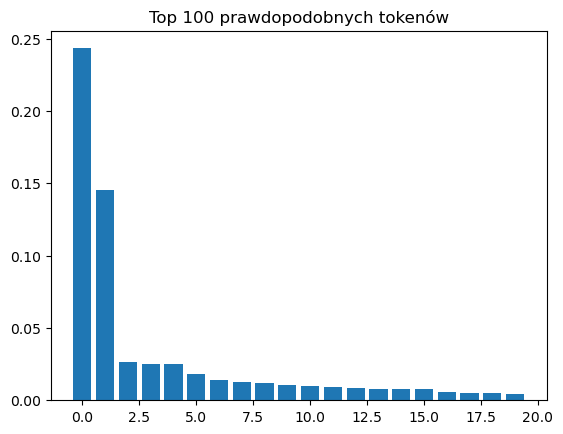

=====How many B's are in ABBBA=====
Token:?
Probability:0.36973658204078674
Token:'s
Probability:0.06334333121776581
Token: and
Probability:0.04807889461517334
Token:,
Probability:0.045348599553108215
Token:?"
Probability:0.02546505630016327
Token: or
Probability:0.011552764102816582
Token:.
Probability:0.0106910839676857
Token: (
Probability:0.00890171155333519
Token: that
Probability:0.00833060871809721
Token:-
Probability:0.008233994245529175
Token: in
Probability:0.005876494571566582
Token: this
Probability:0.004900189582258463
Token:B
Probability:0.004771472420543432
Token:?!
Probability:0.004327702801674604
Token:/
Probability:0.004260380752384663
Token: ?
Probability:0.00422945199534297
Token: at
Probability:0.004208144266158342
Token: for
Probability:0.003913364838808775
Token: right
Probability:0.003501313040032983
Token:

Probability:0.0032650274224579334


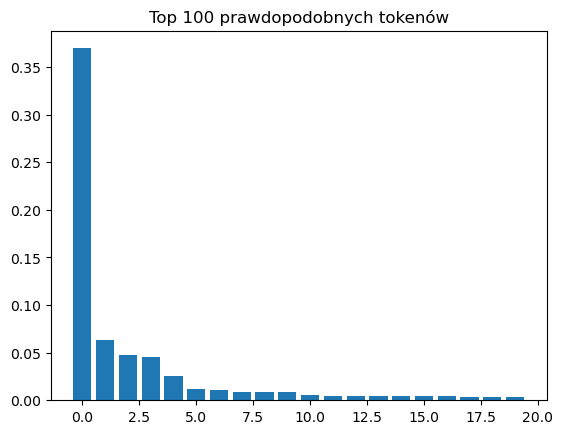

=====Number 2/0 is rational=====
Token:.
Probability:0.18496395647525787
Token:,
Probability:0.1640591323375702
Token: and
Probability:0.06479039788246155
Token:ization
Probability:0.03753243759274483
Token:ized
Probability:0.03463907912373543
Token: in
Probability:0.028598736971616745
Token: to
Probability:0.022000472992658615
Token: for
Probability:0.019317831844091415
Token: (
Probability:0.017913980409502983
Token::
Probability:0.015772288665175438
Token: enough
Probability:0.01296987384557724
Token: if
Probability:0.010775726288557053
Token:izing
Probability:0.009677738882601261
Token:

Probability:0.009554632939398289
Token: because
Probability:0.008537578396499157
Token:;
Probability:0.00785013847053051
Token: when
Probability:0.0073066456243395805
Token: from
Probability:0.00622244318947196
Token: but
Probability:0.00593890156596899
Token: as
Probability:0.005790139548480511


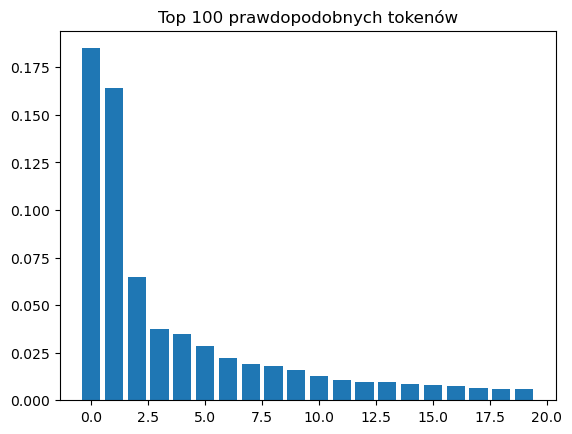

In [36]:
import matplotlib.pyplot as plt
prompts =["Today is","How many B's are in ABBBA","Number 2/0 is rational"]
for p in prompts:
    print(f"====={p}=====")
    inputs = tokenizer.encode(p, return_tensors="pt").to(device)
    
    # Forward pass, bez generacji
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits  # shape: [1, seq_len, vocab_size]
    
    # Softmax dla ostatniego tokena
    import torch.nn.functional as F
    last_token_logits = logits[0, -1, :]
    probs = F.softmax(last_token_logits, dim=-1)
    
    # 100 najbardziej prawdopodobnych tokenów
    top_k = torch.topk(probs, 20)
    for token_id, prob in zip(top_k.indices.tolist(), top_k.values.tolist()):
        print(f"Token:{tokenizer.decode([token_id])}\nProbability:{prob}")
    plt.bar(range(20), top_k.values.cpu().numpy())
    plt.title("Top 100 prawdopodobnych tokenów")
    plt.show()
